Training LinearRegression...
LinearRegression MAE (CV): $52800.18
Training RandomForest...
RandomForest MAE (CV): $32977.22

 Best Model: RandomForestRegressor
Test MAE: $33426.80


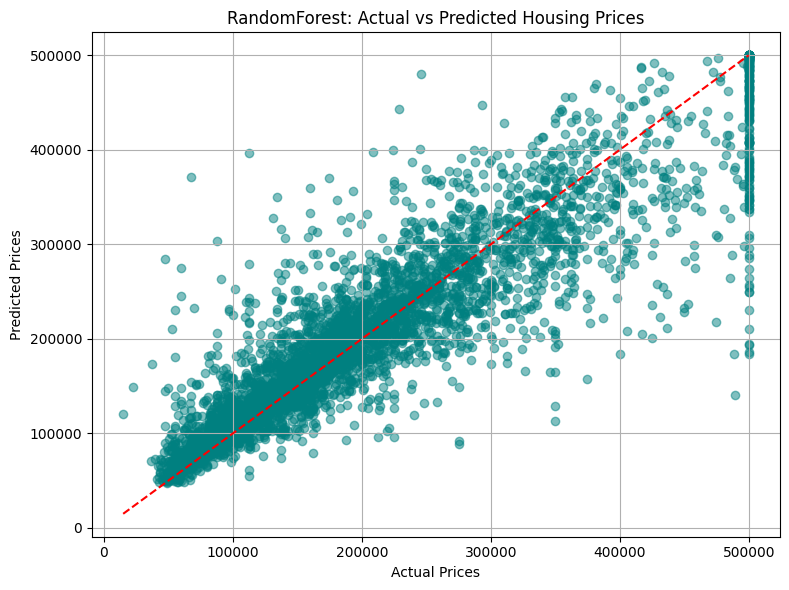

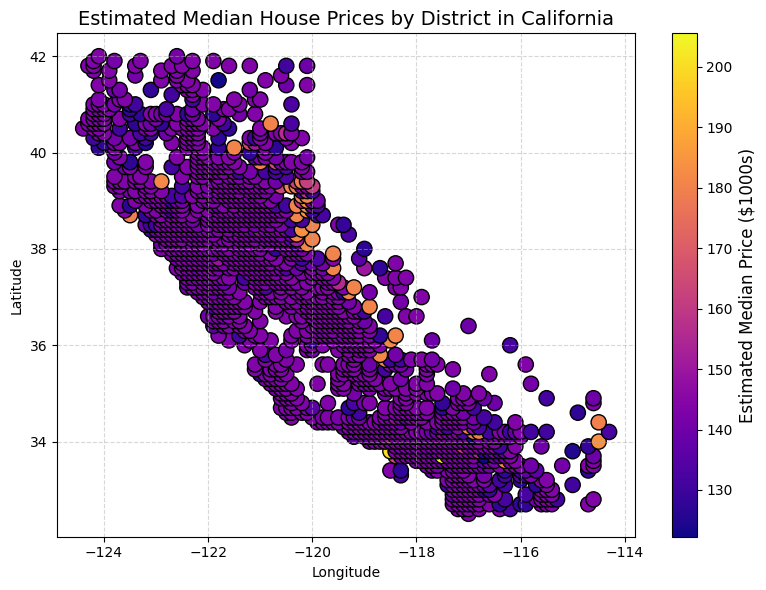

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Load and clean data
df = pd.read_csv('housing.csv')
df.dropna(inplace=True)

# Feature engineering
df['AveRooms'] = df['total_rooms'] / df['households']
df['AveBedrms'] = df['total_bedrooms'] / df['households']
df['AveOccup'] = df['population'] / df['households']

# Features and target
X = df[['median_income', 'housing_median_age', 'AveRooms', 'AveBedrms', 'AveOccup', 'latitude', 'longitude']]
y = df['median_house_value']

# Train/test split for prediction plots
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "LinearRegression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    "RandomForest": GridSearchCV(
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        param_grid={
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10]
        },
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
}

# Evaluate using cross-validation and select the best model
best_model = None
best_score = float('inf')
best_name = ""

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    if isinstance(model, GridSearchCV):
        score = -model.best_score_
        trained_model = model.best_estimator_
    else:
        # Cross-validation scoring for models without grid search
        score = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
        trained_model = model

    print(f"{name} MAE (CV): ${score:.2f}")

    if score < best_score:
        best_score = score
        best_model = trained_model
        best_name = name

# Predict and evaluate on test set
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"\n Best Model: {type(best_model.named_steps['model']).__name__}")
print(f"Test MAE: ${test_mae:.2f}")

# Predict over the full dataset
df_features = scaler.transform(df[features])
df['predicted_price'] = best_model.predict(df_features)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"{best_name}: Actual vs Predicted Housing Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Median Price by District (rounded lat/lon) ----
df['district_lat'] = df['latitude'].round(1)
df['district_lon'] = df['longitude'].round(1)

# Calculate median price per pseudo-district
district_prices = df.groupby(['district_lat', 'district_lon'])['predicted_price'].median().reset_index()
district_prices.rename(columns={'predicted_price': 'estimated_median_price'}, inplace=True)

# ---- Map Plot ----
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    district_prices['district_lon'], district_prices['district_lat'],
    c=district_prices['estimated_median_price'] / 1000, cmap='plasma', edgecolor='k', s=120
)
cbar = plt.colorbar(sc)
cbar.set_label('Estimated Median Price ($1000s)', fontsize=12)
plt.title('Estimated Median House Prices by District in California', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()